In [1]:
import numpy as np
import pandas as pd

from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
import seaborn as sns
from cycle_prediction.t2e import t2e
import pandas as pd
from matplotlib import gridspec
import seaborn as sns
import pickle
import pickle
import warnings
warnings.filterwarnings("ignore")
import os
%load_ext autoreload
%autoreload 2

C:\Users\ebasfad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
path = '../data/'

a = os.path.join(path,'helpdesk.csv')
a = pd.read_csv(a)
b = os.path.join(path,'bpi_12_w.csv')
b = pd.read_csv(b)
c = os.path.join(path,'bpi_12_w_no_repeat.csv')
c = pd.read_csv(c)
d = os.path.join(path,'env_permit.csv')
d = pd.read_csv(d)

df_name = {
    'a':'helpdesk',
    'b':'bpi_12_w',
    'c':'bpi_12_w_no_repeat',
    'd':'env_permit'
}

df_dict = {
    'a': a,
    'b': b,
    'c': c,
    'd': d
}
range_dict = {
    'a': range(2,8,1),
    'b': range(2,22,2),
    'c': range(2,12,2),
    'd': range(2,22,2)
}

[]

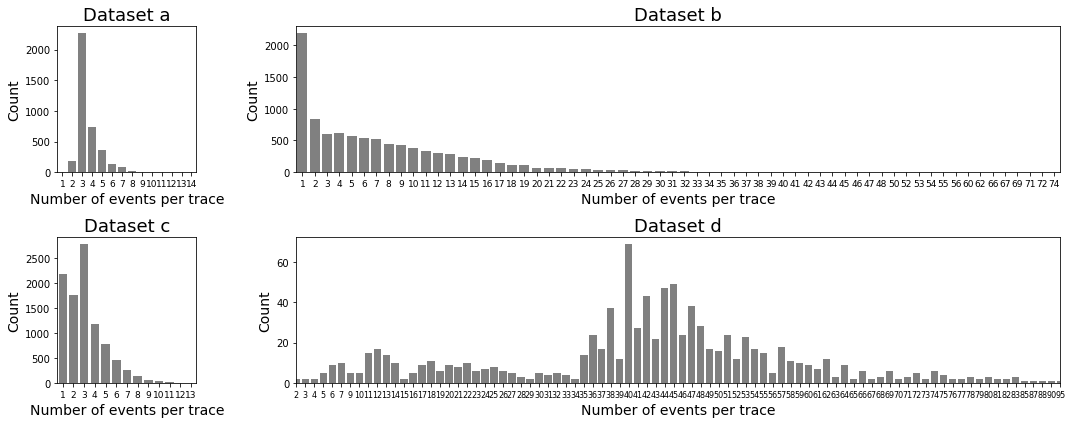

In [27]:
fig = plt.figure(figsize=(15, 6)) 
gs = gridspec.GridSpec(2, 2, width_ratios=[2,11])

i = 0
for key, dataset in df_dict.items():

    ax = plt.subplot(gs[i])
    sns.countplot(dataset.groupby(["CaseID"]).agg({"ActivityID":'count'})["ActivityID"], color='gray', ax = ax)
    if key == 'd':
        plt.xticks(rotation=0, fontsize=8)
        plt.xlim((0,85))
    else:
        plt.xticks(rotation=0, fontsize=9)
    plt.xlabel("Number of events per trace", fontsize=14)
    plt.ylabel("Count",fontsize=14)
    plt.title("Dataset " + key,fontsize=18)
    i+=1
plt.tight_layout()
plt.plot()

[]

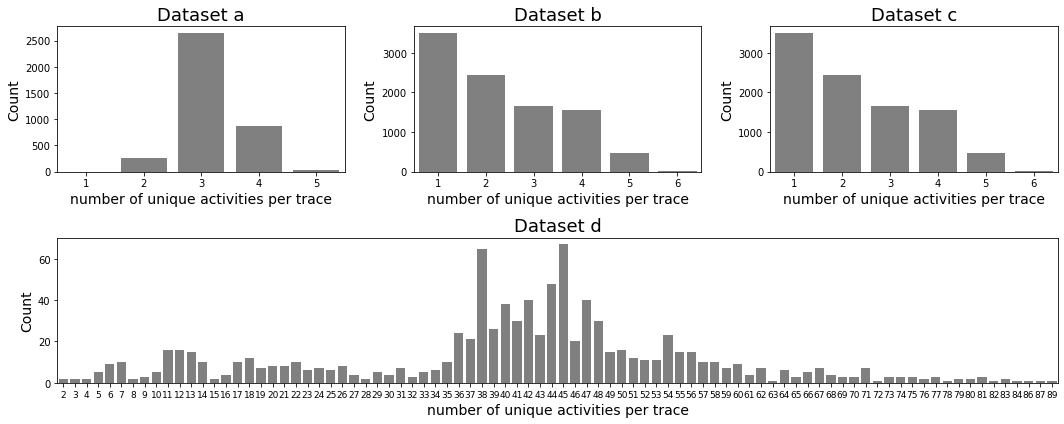

In [25]:
from matplotlib import gridspec
fig = plt.figure(figsize=(15, 6)) 
gs = gridspec.GridSpec(2, 3, width_ratios=[1,1,1])

i = 0
for key, dataset in df_dict.items():

    ax = plt.subplot(gs[i])
    if i == 3:
        ax = plt.subplot(gs[i:])
        plt.xlim((0,85))
        plt.xticks(rotation=0, fontsize=9)
    sns.countplot(dataset.groupby(["CaseID"]).agg({"ActivityID":'nunique'})["ActivityID"], color='gray', ax = ax)
    plt.xlabel("number of unique activities per trace", fontsize=14)
    plt.ylabel("Count",fontsize=14)
    plt.title("Dataset " + key,fontsize=18)
    i+=1
plt.tight_layout()
plt.plot()

In [34]:
dataset='a'
res='s'
censored=False
cen_per=0
fit_type:'t2e'
df_results = dict()
prefix = 6
transform = True
##########################################################

print("\ndataset:", dataset, "\tprefix:", prefix)

t2e_obj = t2e(df_dict[dataset],
              prefix = prefix,
              resolution = res,
              censored = censored,
              cen_prc = cen_per,
              fit_type = 't2e',
              transform = transform
             )
t2e_obj.preprocess_dev()
X_train, X_test, X_val, y_train, y_test, y_val, len_train, len_val, len_test = t2e_obj.smart_split(train_prc = 0.7,
                                                                                                     val_prc = 0.45,
                                                                                                      scaling=True)


dataset: a 	prefix: 6
all cases 126
first 10 censored cases []
	Total Observed: 126
	Training data Observed: 49
	Training data Censored: 0
	Training data to use: 49
	Validation data: 39
	Testing data   : 38


In [35]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((49, 6, 10), (38, 6, 10), (39, 6, 10), (49, 2), (38, 2), (39, 2))

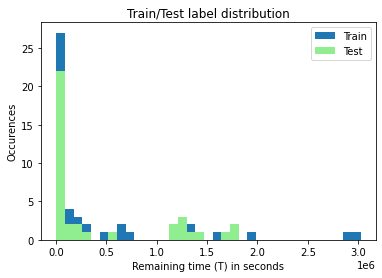

In [36]:
if res == 'd':
    bins = np.arange(0,y_train.max()+1, 1)
elif res == 'h':
    bins = np.arange(0,y_train.max()+24, 24)
elif res == 's':
    bins = np.arange(0,y_train.max()+86400, 86400)
    
plt.figure(figsize=(6,4))
plt.hist(y_train[:,0], bins = bins,label="Train");
# plt.hist(y_val[:,0], bins = bins,label="Val");
plt.hist(y_test[:,0], bins = bins, label="Test", color='lightgreen');
plt.xlabel('Remaining time (T) in seconds')
plt.ylabel('Occurences')
plt.title('Train/Test label distribution')
plt.legend()
plt.show()

0.3333333333333333 3.0


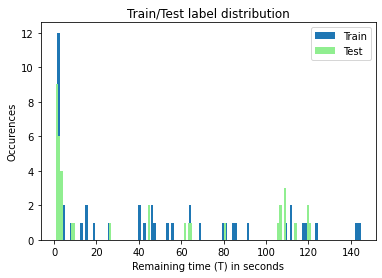

In [37]:
root = 3
root = 1/root
power = 1/root
print(root, power)

plt.figure(figsize=(6,4))
y_conv = (y_train[:,0]**root)

plt.hist(y_conv, bins = 120,label="Train", alpha =1);

y_conv = (y_test[:,0]**root)
# y_conv = (np.log(y_test[:,0]))
plt.hist(y_conv, bins = 120,label="Test", alpha=1, color='lightgreen');

plt.xlabel('Remaining time (T) in seconds')
plt.ylabel('Occurences')
plt.title('Train/Test label distribution')
plt.legend()
plt.show()

In [38]:
print("Layer size:",4, end = " ..... ")
t2e_obj.fit(X_train, y_train, X_val, y_val,size=8, vb = True)
print("Done")
print("Training accomplished in", t2e_obj.fit_time, "seconds")
try:
    test_result_df, mae, accuracy = t2e_obj.evaluate(X_test,y_test)
    print('power:', t2e_obj.power)
    print(len(test_result_df['T_pred'].unique()), 'unique predictions')
    print(np.round(mae,3), 'mae')
except:
    print('evaluation failed')


Layer size: 4 ..... Y_label has been transformed


Epoch 1/500

Epoch 00001: val_loss improved from inf to 2.19987, saving model to output/best_model.h5
1/1 [==============================] - 0s 249ms/step - loss: 2.5783 - val_loss: 2.1999
Epoch 2/500

Epoch 00002: val_loss did not improve from 2.19987
1/1 [==============================] - 0s 106ms/step - loss: 2.7427 - val_loss: 2.2023
Epoch 3/500

Epoch 00003: val_loss did not improve from 2.19987
1/1 [==============================] - 0s 107ms/step - loss: 2.3641 - val_loss: 2.2057
Epoch 4/500

Epoch 00004: val_loss did not improve from 2.19987
1/1 [==============================] - 0s 109ms/step - loss: 2.4424 - val_loss: 2.2026
Epoch 5/500

Epoch 00005: val_loss did not improve from 2.19987
1/1 [==============================] - 0s 123ms/step - loss: 2.3563 - val_loss: 2.2072
Epoch 6/500

Epoch 00006: val_loss did not improve from 2.19987
1/1 [==============================] - 0s 120ms/step - loss: 2.1901 - val_loss: 2.2082
Epoch


Epoch 00046: val_loss improved from 2.13220 to 2.12980, saving model to output/best_model.h5
1/1 [==============================] - 0s 137ms/step - loss: 1.6385 - val_loss: 2.1298
Epoch 47/500

Epoch 00047: val_loss improved from 2.12980 to 2.12792, saving model to output/best_model.h5
1/1 [==============================] - 0s 130ms/step - loss: 1.6558 - val_loss: 2.1279
Epoch 48/500

Epoch 00048: val_loss did not improve from 2.12792
1/1 [==============================] - 0s 117ms/step - loss: 1.6571 - val_loss: 2.1292
Epoch 49/500

Epoch 00049: val_loss did not improve from 2.12792
1/1 [==============================] - 0s 111ms/step - loss: 1.6489 - val_loss: 2.1281
Epoch 50/500

Epoch 00050: val_loss improved from 2.12792 to 2.12686, saving model to output/best_model.h5
1/1 [==============================] - 0s 132ms/step - loss: 1.6421 - val_loss: 2.1269
Epoch 51/500

Epoch 00051: val_loss did not improve from 2.12686
1/1 [==============================] - 0s 115ms/step - loss: 1

In [39]:
y_pred = t2e_obj.predict(X_test)

In [40]:
test_results_df, mae = t2e_obj.evaluate(X_test,y_test)

Y_label is restored


In [41]:
mae

4.784490016123222

In [42]:
test_results_df

,T,U,alpha,beta,T_pred,error (days),MAE,Accurate
0,12.0,1.0,42.311066,1.001129,0.000111,0.000139,0.000139,True
1,718.0,1.0,45.835339,1.095003,118.823113,0.006935,0.006935,True
2,7.0,1.0,39.970264,0.928563,0.000000,0.000081,0.000081,True
3,258568.0,1.0,49.024685,1.044315,13.461747,2.992529,2.992529,False
4,1723975.0,1.0,40.081902,0.960338,0.000000,19.953414,19.953414,False
5,86515.0,1.0,35.214458,0.949213,0.000000,1.001331,1.001331,True
6,11.0,1.0,31.560442,0.972861,0.000000,0.000127,0.000127,True
7,1787930.0,1.0,42.073074,0.977916,0.000000,20.693634,20.693634,False
8,5.0,1.0,39.926029,0.941026,0.000000,0.000058,0.000058,True
9,44.0,1.0,41.296661,0.967681,0.000000,0.000509,0.000509,True
